In [2]:

%pip install numpy scikit-learn hmmlearn biopython matplotlib
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
from Bio import SeqIO
from Bio.Align import PairwiseAligner
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import os

In [4]:
import os
import pandas as pd

# Folder containing all CSV files
folder_path = r'C:\Users\vivek\OneDrive\Documents\Clg stuff\Ai and ML\TY projects\Gene Idenfication\Data'

# Create an empty list to hold DataFrames from each file
dataframes = []

# Loop through all CSV files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        # Read the CSV file with low_memory=False to handle mixed types better
        df = pd.read_csv(file_path, low_memory=False)
        # Append to the list
        dataframes.append(df)
        


# Concatenate all DataFrames into a single DataFrame
data = pd.concat(dataframes, ignore_index=True)
if 'metadata' in data.columns:
    data.drop(columns=['metadata'], inplace=True)
else:
    print("'metadata' column not found, skipping the drop.")

# Preview the combined dataset
print(data.head())


'metadata' column not found, skipping the drop.
        # rsid chromosome  position genotype
0   rs12564807          1    734462       AA
1    rs3131972          1    752721       AG
2  rs148828841          1    760998       AC
3   rs12124819          1    776546       AG
4  rs115093905          1    787173       GG


In [5]:
print(data.isnull().sum())


# rsid        0
chromosome    0
position      0
genotype      0
dtype: int64


In [6]:
print(data.columns)


Index(['# rsid', 'chromosome', 'position', 'genotype'], dtype='object')


In [7]:
# Rename columns for convenience
data.rename(columns={
    '# rsid': 'rsid',
    '# This data file generated by 23andMe at: Wed Jan 25 11:45:20 2017': 'metadata'
}, inplace=True)



In [8]:
# Fill missing values in categorical columns
data['genotype'].fillna(value='unknown', inplace=True)


In [9]:
data['position'] = pd.to_numeric(data['position'], errors='coerce')


In [10]:
# Drop rows where 'position' couldn't be converted to numeric (NaN values)
data_cleaned1 = data.dropna(subset=['position'])

print(data_cleaned1.dtypes)

rsid          object
chromosome    object
position       int64
genotype      object
dtype: object


In [11]:
print(data.dtypes)


rsid          object
chromosome    object
position       int64
genotype      object
dtype: object


In [12]:
# Update the genotype-to-numeric mapping to handle all variants
genotype_to_num = {
    'AA': 0, 'AG': 1, 'AC': 2, 'AT': 3, 
    'GG': 4, 'GC': 5, 'GT': 6, 'CC': 7, 
    'CT': 8, 'TT': 9, 'unknown': -1,  # Existing mappings

    # Additional genotypes
    'CG': 10, '--': 11, 'II': 12, 'DD': 13, 'DI': 14, 
    'G': 15, 'A': 16, 'T': 17, 'C': 18, 
    'I': 19, 'D': 20  # Single nucleotide or other special variants
}

# Apply the updated mapping to the dataset
data['genotype_numeric'] = data['genotype'].map(genotype_to_num)

# Handle unmapped genotypes if any still exist
print("Number of unmapped genotypes:", data['genotype_numeric'].isnull().sum())  # Should return 0 if all are mapped

# Drop rows with NaN values in 'genotype_numeric'
data_cleaned = data.dropna(subset=['genotype_numeric'])

# Reshape the genotype_numeric column to match HMM input requirements
sequence_data = data_cleaned['genotype_numeric'].values.reshape(-1, 1)

# View the first few rows of the cleaned dataset
print(data_cleaned.head(30))


Number of unmapped genotypes: 0
           rsid chromosome  position genotype  genotype_numeric
0    rs12564807          1    734462       AA                 0
1     rs3131972          1    752721       AG                 1
2   rs148828841          1    760998       AC                 2
3    rs12124819          1    776546       AG                 1
4   rs115093905          1    787173       GG                 4
5    rs11240777          1    798959       GG                 4
6     rs7538305          1    824398       AA                 0
7     rs4970383          1    838555       AC                 2
8     rs4475691          1    846808       CT                 8
9     rs7537756          1    854250       AG                 1
10   rs13302982          1    861808       GG                 4
11   rs55678698          1    864490       CC                 7
12     i6019299          1    871267       CC                 7
13    rs1110052          1    873558       GT                 6
14  rs14

In [13]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM

# Your previous cleaned dataset 'data_cleaned' is already set up
print(data_cleaned.head())

# Let's normalize the 'position' column for better results in sequence modeling
data_cleaned['position'] = (data_cleaned['position'] - data_cleaned['position'].mean()) / data_cleaned['position'].std()

# Now, we select only the features we need for the HMM
# Keep 'position' and one-hot encoded 'chromosome' columns, plus 'genotype_numeric' as observation
X = pd.get_dummies(data_cleaned[['position', 'chromosome']], columns=['chromosome'], drop_first=True)

# Observations are the 'genotype_numeric' column, representing the numeric encoding of the genotype
observations = data_cleaned['genotype_numeric'].values


# We now treat 'observations' as a sequence for the HMM


          rsid chromosome  position genotype  genotype_numeric
0   rs12564807          1    734462       AA                 0
1    rs3131972          1    752721       AG                 1
2  rs148828841          1    760998       AC                 2
3   rs12124819          1    776546       AG                 1
4  rs115093905          1    787173       GG                 4


In [14]:
# Ensure chromosome is treated as a string
data_cleaned['chromosome'] = data_cleaned['chromosome'].astype(str)

# One-hot encode the chromosome column (without dropping any data)
X = pd.get_dummies(data_cleaned[['position', 'chromosome']], columns=['chromosome'])

# Check the shape again after fixing
print("X shape after re-encoding:", X.shape)


X shape after re-encoding: (3679916, 26)


In [15]:
# Ensure no rows with missing values remain (just in case)
data_cleaned.dropna(subset=['position', 'genotype_numeric'], inplace=True)

# Reapply one-hot encoding after dropping NaN values
X = pd.get_dummies(data_cleaned[['position', 'chromosome']], columns=['chromosome'])



# Check if shapes match now
print("X shape:", X.shape)

print("Observations shape:", observations.shape)


X shape: (3679916, 26)
Observations shape: (3679916,)


In [16]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

# Example sequences (replace with actual sequences from your data)
sequence1 = "ACTG"
sequence2 = "ACG"

# Perform alignment
alignments = pairwise2.align.globalxx(sequence1, sequence2)

# Print alignments
for alignment in alignments:
    print(format_alignment(*alignment))


ACTG
|| |
AC-G
  Score=3



C:\Users\vivek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [42]:
def compute_gc_content(sequence):
    gc_count = sequence.count('G') + sequence.count('C')
    return gc_count / len(sequence)

# Assuming you have access to sequences in the data
data_cleaned['gc_content'] = data_cleaned['genotype'].apply(compute_gc_content)

# You can then include this new feature in the HMM observations
X = np.column_stack([data_cleaned['position'], data_cleaned['gc_content']])


In [1]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import MultinomialHMM
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt

# Drop missing values and ensure 'genotype_numeric' is non-negative
data_cleaned = data_cleaned.dropna(subset=['genotype_numeric'])
data_cleaned = data_cleaned[data_cleaned['genotype_numeric'] >= 0]

# One-hot encode the 'chromosome' column and add it to the dataset
chromosome_encoded = pd.get_dummies(data_cleaned['chromosome'], prefix='chromosome')

# Concatenate the one-hot encoded chromosome data with 'position' and 'genotype_numeric'
# Use 'position', 'gc_content', and 'chromosome_encoded' as features
X = pd.concat([data_cleaned[['position', 'gc_content']], chromosome_encoded], axis=1)


# Convert 'genotype_numeric' into observations for the HMM
observations = data_cleaned['genotype_numeric'].values.reshape(-1, 1)

# Initialize the HMM model (experiment with the number of hidden states)
n_states = 2  # Adjust this number based on experimentation
hmm_model = MultinomialHMM(n_components=4, n_iter=200,random_state=42)


# Fit the model
hmm_model.fit(observations)

# Predict hidden states
predicted_states = hmm_model.predict(observations)

# Add the predicted states back to the dataset
data_cleaned['predicted_states'] = predicted_states

# View the results
print(data_cleaned[['position', 'chromosome', 'genotype', 'predicted_states']].head(100))






NameError: name 'data_cleaned' is not defined

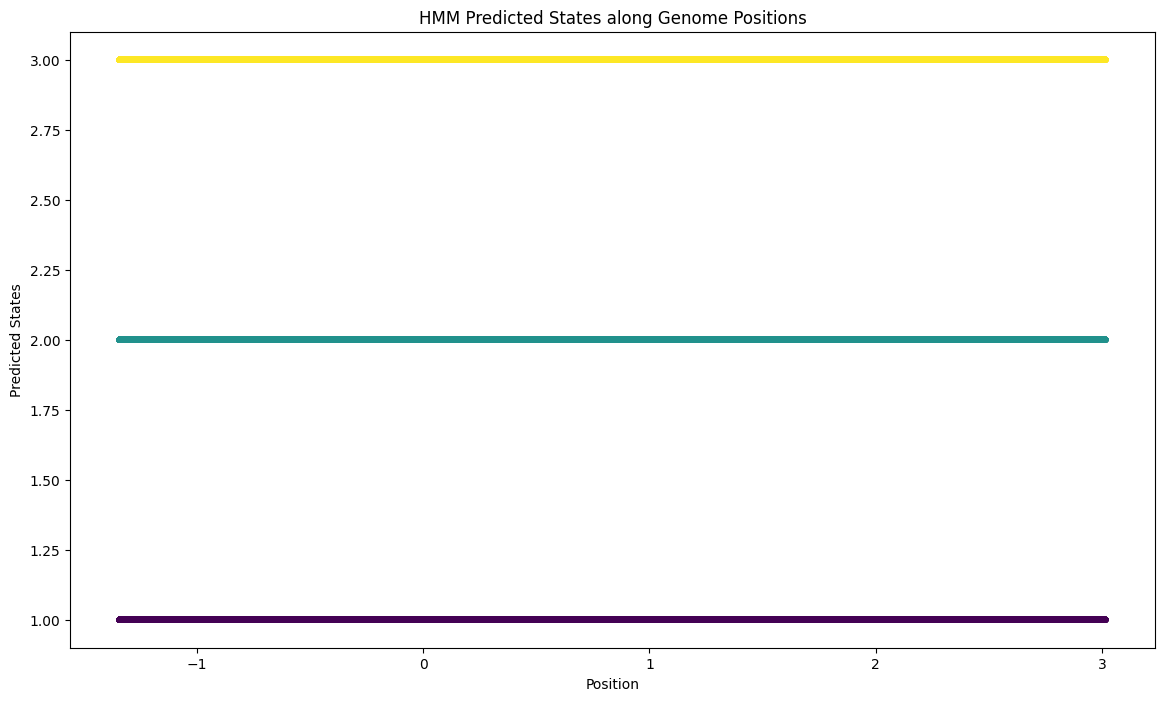

In [50]:
plt.figure(figsize=(14, 8))
plt.scatter(data_cleaned['position'], data_cleaned['predicted_states'], c=data_cleaned['predicted_states'], cmap='viridis', s=10)
plt.xlabel('Position')
plt.ylabel('Predicted States')
plt.title('HMM Predicted States along Genome Positions')
plt.show()

C:\Users\vivek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


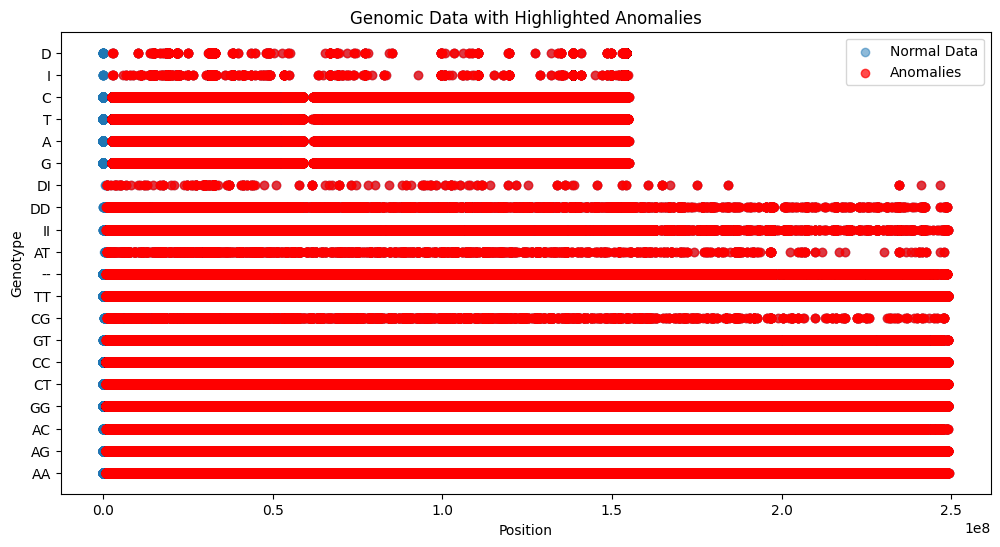

In [39]:
# Define a threshold for anomalies (example: position > 1,000,000)
threshold = 1000000

# Scatter plot of positions, highlighting anomalies
plt.figure(figsize=(12, 6))
plt.scatter(data['position'], data['genotype'], label='Normal Data', alpha=0.5)

# Highlight the anomalies
anomalies = data[data['position'] > threshold]
plt.scatter(anomalies['position'], anomalies['genotype'], color='red', label='Anomalies', alpha=0.7)

plt.xlabel('Position')
plt.ylabel('Genotype')
plt.title('Genomic Data with Highlighted Anomalies')
plt.legend()
plt.show()


In [6]:
%pip install streamlit


Note: you may need to restart the kernel to use updated packages.
